In [1]:
import yfinance as yf
import pandas as pd

def create_df_for_multi_companies(
        raw_data_multiindex:pd.MultiIndex, 
        stock_var:str, 
        companies:list[str]):
    
    raw_values = {}
    for company in companies:
        # Transform MultiIndex DF into SingleIndex DF for each company with all prices (Open, Close... Adj. Close)
        raw_data_by_company = raw_data_multiindex.xs(key=company, level='Ticker', axis=1, drop_level=False)
        # Grab only the Datetime and the desired price (e.g., colums -> [Datetime | Open])
        raw_data_series = raw_data_by_company[(stock_var,company)]
        # Make a dictionary of type {company[x] : [Open Values 0, 1, ... N] ... }
        raw_values[company] = raw_data_series.values
    # Create 'df' Dataframe only with "Datetime" Column
    df = pd.DataFrame({'Datetime':raw_data_series.index})
    # Append all columns with values for each company, resulting in [Datetime | Company_values[x] ...]
    df = df.assign(**raw_values)
    return df

def get_finance_df(
        companies:str|list[str], 
        start_date:str, 
        end_date:str, 
        stock_var:str='Adj Close') -> pd.DataFrame:
    
    try:
        # In case companies is a string, transform into a list of 1 object, like: ['company']
        if not isinstance(companies,list):
            companies:list[str] = [companies]
        
        # Download data using yfinance
        raw_data_multiindex:pd.MultiIndex = yf.download(tickers=companies, start=start_date, end=end_date)

        # Transform the raw data into a suitable DF
        df = create_df_for_multi_companies(raw_data_multiindex, stock_var, companies)

        return df
    
    except:
            Exception("Unexpected error: something wrong occurred while creating the finance DF")


def split_train_test_valid_df(df, horizon_pred=1, seq_length=30, size_train_percent=0.75, size_test_percent=0.2):
    N = len(df)-seq_length-horizon_pred
    Ntrain = int(size_train_percent*N)
    Ntest = int(size_test_percent*N)
    
    df_train = df.loc[0:Ntrain]
    df_test = df.loc[Ntrain+1:Ntrain+Ntest]
    df_valid = df.loc[Ntrain+Ntest+1:]

    Nvalid = len(df_valid)
    if (Nvalid < (seq_length+horizon_pred+1)):
        raise ValueError(f"""At least (seq_length+horizon_pred+1) samples are needed for validation. You have seq_length={seq_length}, horizon_pred={horizon_pred} and Nvalid={Nvalid} samples, with Ntrain={Ntrain}, Ntest={Ntest} and N={N}. Try changing the prediction horizon, the sequence/window length, or increasing the number of samples""")

    return (df_train, df_test, df_valid)

def shift_drop_na_in_xy(df, company_inputs, company_output, horizon_pred):
    new_df = pd.concat([df[company_inputs], df[company_output].rename("target").shift(-horizon_pred)],axis='columns').dropna()
    X = new_df[company_inputs].values
    y = new_df["target"].values
    return X, y

In [2]:
# from feature_engineering import get_finance_df

# Load dataset
# company_inputs = ['PETR4.SA', 'BZ=F', '6L=F']
# company_inputs = ['PETR4.SA', 'BZ=F']
# company_inputs = ['PETR4.SA', '6L=F']
company_inputs = ['PETR4.SA']
company_output = 'PETR4.SA'
stock_var = 'Adj Close'

end_date = '2024-10-30' 
start_date = '2017-01-01'

horizon_pred = 1
seq_length = 20
batch_size = 30
train_ratio = 0.8
test_ratio = 0.15

units_layer1 = 250
activation_layer1 = 'relu'
dropout_layer1 = 0.2
units_layer2 = None
activation_layer2 = None if units_layer2 is None else 'relu'
dropout_layer2 = None if units_layer2 is None else 0.1
activation_output = 'relu'

optim = 'adam'
loss_fn = 'mse'
n_epochs = 150

df = get_finance_df(company_inputs, start_date, end_date, stock_var)
df = df.interpolate(method='linear')
# df = df.fillna(0)
# df.dropna()

n_inputs = len(company_inputs)

print(df)
print(n_inputs)


[*********************100%***********************]  1 of 1 completed

                      Datetime   PETR4.SA
0    2017-01-02 00:00:00+00:00   4.705652
1    2017-01-03 00:00:00+00:00   4.975282
2    2017-01-04 00:00:00+00:00   4.975282
3    2017-01-05 00:00:00+00:00   5.055527
4    2017-01-06 00:00:00+00:00   5.026639
...                        ...        ...
1947 2024-10-23 00:00:00+00:00  35.660000
1948 2024-10-24 00:00:00+00:00  35.900002
1949 2024-10-25 00:00:00+00:00  36.150002
1950 2024-10-28 00:00:00+00:00  36.090000
1951 2024-10-29 00:00:00+00:00  36.009998

[1952 rows x 2 columns]
1


In [3]:
df_train, df_test, df_valid = split_train_test_valid_df(df=df, 
    horizon_pred=horizon_pred, seq_length=seq_length, 
    size_train_percent=train_ratio, size_test_percent=test_ratio
    )

In [4]:
X_train, y_train = shift_drop_na_in_xy(df_train, company_inputs, company_output, horizon_pred=horizon_pred)
X_test, y_test = shift_drop_na_in_xy(df_test, company_inputs, company_output, horizon_pred=horizon_pred)
X_valid, y_valid = shift_drop_na_in_xy(df_valid, company_inputs, company_output, horizon_pred=horizon_pred)

In [5]:
X_train[0:3], y_train[0:3]

(array([[4.70565176],
        [4.97528172],
        [4.97528172]]),
 array([4.97528172, 4.97528172, 5.05552673]))

In [6]:
# Import necessary libraries
from sklearn.preprocessing import MinMaxScaler

# Normalize the Price column
scalerX = MinMaxScaler()
scalery = MinMaxScaler()
scaled_X_train = scalerX.fit_transform(X_train)
scaled_y_train = scalery.fit_transform(y_train.reshape(-1, 1))

scaled_X_test = scalerX.transform(X_test)
scaled_y_test = scalery.transform(y_test.reshape(-1, 1))

scaled_X_valid = scalerX.transform(X_valid)
scaled_y_valid = scalery.transform(y_valid.reshape(-1, 1))

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Initialize generator with multivariable input and single target
generator_train = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=seq_length, batch_size=batch_size)
generator_test = TimeseriesGenerator(scaled_X_test, scaled_y_test, length=seq_length, batch_size=batch_size)
generator_valid = TimeseriesGenerator(scaled_X_valid, scaled_y_valid, length=seq_length, batch_size=batch_size)


In [7]:
scaled_X_train, scaled_y_train

(array([[0.04786905],
        [0.06118372],
        [0.06118372],
        ...,
        [0.62819232],
        [0.61374587],
        [0.59963548]]),
 array([[0.06118372],
        [0.06118372],
        [0.06514632],
        ...,
        [0.61374587],
        [0.59963548],
        [0.5969478 ]]))

In [8]:
Xgen_train, ygen_train = generator_train[0]

In [9]:
scalerX.inverse_transform(Xgen_train[0]), scalery.inverse_transform(ygen_train[0].reshape(-1,1)) 

(array([[4.70565176],
        [4.97528172],
        [4.97528172],
        [5.05552673],
        [5.02663898],
        [4.92071247],
        [4.96886063],
        [5.02663898],
        [5.10367441],
        [5.03305817],
        [5.05552673],
        [5.07799673],
        [5.06836605],
        [5.06194687],
        [5.13577318],
        [5.13256359],
        [5.14861536],
        [5.07157707],
        [5.01379919],
        [4.76343012]]),
 array([[4.82120705]]))

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.regularizers import l1, l2, l1_l2

# Define the LSTM model

if (units_layer2 is None) or (activation_layer2 is None):
    print("layers = 1")
    model = Sequential([
            LSTM(units=units_layer1, activation=activation_layer1, input_shape=(seq_length, n_inputs),
                kernel_regularizer=l2(0.01), 
                recurrent_regularizer=l2(0.01), 
                bias_regularizer=l2(0.001),
                recurrent_dropout=dropout_layer1),
        Dropout(rate=dropout_layer1),
        Dense(1, activation=activation_output)
    ])
else:
    print("layers = 2")
    model = Sequential([
        LSTM(units=units_layer1, activation=activation_layer1, input_shape=(seq_length, n_inputs), return_sequences=True),
        Dropout(rate=dropout_layer1),
        LSTM(units=units_layer2, activation=activation_layer2),
        Dropout(rate=dropout_layer2),
        Dense(1, activation=activation_output)
    ])

model.compile(optimizer=optim, loss=loss_fn)

# Train the model
hist = model.fit(generator_train, epochs=n_epochs, validation_data=generator_test)


layers = 1
Epoch 1/150


c:\GitRepos\TC4-Thales\tech_challenge_4\training_model\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\GitRepos\TC4-Thales\tech_challenge_4\training_model\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 1.8143 - val_loss: 0.4346
Epoch 2/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.3384 - val_loss: 0.2569
Epoch 3/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2192 - val_loss: 0.2473
Epoch 4/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1894 - val_loss: 0.2807
Epoch 5/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1702 - val_loss: 0.2731
Epoch 6/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1515 - val_loss: 0.1704
Epoch 7/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1353 - val_loss: 0.1601
Epoch 8/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1199 - val_loss: 0.1725
Epoch 9/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1062 - val_loss: 0.1307
Epoch 10/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0943 - val_loss: 0.1031
Epoch 11/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0845 - val_loss: 0.1270
Epoch 12/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0

In [ ]:
# import matplotlib.pyplot as plt

# # Plot the predicted prices
# plt.plot(hist['loss'], label="Train Loss")
# plt.plot(hist['val_loss'], label="Test Loss")
# plt.xlabel("Epoch")
# plt.ylabel("MSE")
# plt.legend()
# plt.show()

TypeError: 'History' object is not subscriptable

In [12]:
X_gen_valid, y_gen_valid = generator_valid[0]
y_pred_scaled = model.predict(X_gen_valid).reshape(-1,)
print(y_pred_scaled)
print(y_gen_valid[1:].reshape(-1,))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
[1.3082166 1.2872688 1.2793956 1.2956395 1.3041593 1.318846  1.3295506
 1.3416204 1.3469846 1.3507198 1.3639832 1.376756  1.3937118 1.3998122
 1.3904479 1.3762667 1.3730016 1.3883661 1.3957169 1.3926814 1.3959854
 1.3942877 1.3999077 1.4008205 1.4049546 1.405691  1.4090017 1.3964279
 1.3812264 1.3793054]
[1.53922942 1.54066973 1.56803812 1.57716091 1.59492653 1.59348584
 1.59636684 1.62613606 1.64246099 1.67030973 1.66454773 1.63237805
 1.6074103  1.61701327 1.66118675 1.66070677 1.64342132 1.65590529
 1.64726266 1.66406775 1.65926627 1.66886923 1.66550806 1.67319054
 1.636219   1.61269195 1.6270964  1.62469556 1.62277508]


In [13]:
y_pred = scalery.inverse_transform(y_pred_scaled.reshape(-1,1))
y_valid_f = scalery.inverse_transform(y_gen_valid.reshape(-1,1))
print(y_pred.T, y_valid_f.T)

[[30.22843  29.804224 29.644787 29.973736 30.146267 30.443682 30.660456
  30.904877 31.013506 31.089146 31.357735 31.616392 31.959759 32.083294
  31.893661 31.606485 31.540363 31.851505 32.000362 31.93889  32.0058
  31.97142  32.085228 32.103714 32.18743  32.202343 32.269386 32.01476
  31.706923 31.668018]] [[33.84673691 34.90657425 34.93574142 35.48996735 35.67470932 36.03447342
  36.00529861 36.06364059 36.66648483 36.99707413 37.56102753 37.44434357
  36.79288864 36.28727722 36.48174286 37.37628174 37.36656189 37.01652145
  37.26932907 37.09431076 37.43462372 37.3373909  37.53185654 37.46379089
  37.61936569 36.87067032 36.3942337  36.68593216 36.63731384 36.598423  ]]


In [28]:
from sklearn.metrics import root_mean_squared_error, r2_score

delay = 2
offset = 5

rmse = root_mean_squared_error(y_pred[delay:]+offset, y_valid_f[0:-delay])
r2 = r2_score(y_pred[delay:]+offset, y_valid_f[0:-delay])

print(f'RMSE: {rmse:.4f}')
print(f'R² Score: {r2:.4f}')

RMSE: 0.3081
R² Score: 0.8177


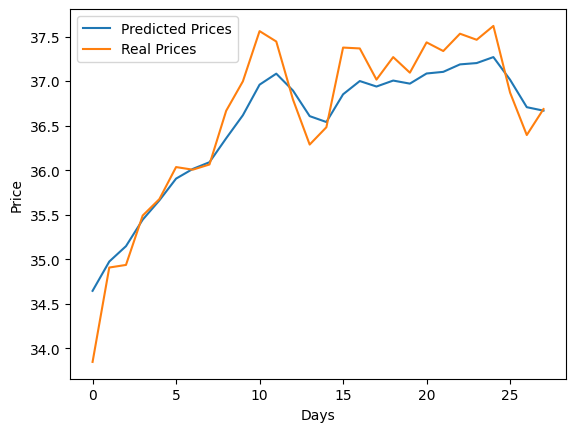

In [29]:
import matplotlib.pyplot as plt

# Plot the predicted prices
plt.plot(y_pred[delay:]+offset, label="Predicted Prices")
plt.plot(y_valid_f[0:-delay], label="Real Prices")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()

In [ ]:
# import mlflow
# import mlflow.tensorflow

# mlflow.set_tracking_uri(uri="http://127.0.0.1:7777")
# mlflow.set_experiment("LSTM Experiments")

# from sklearn.metrics import root_mean_squared_error, r2_score

# mlflow.tensorflow.autolog()
# with mlflow.start_run():
#     mlflow.tensorflow.log_model(model, "model")

#     # Calculate RMSE and R² score
#     rmse = root_mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)

#     print(f'RMSE: {rmse:.4f}')
#     print(f'R² Score: {r2:.4f}')

#     mlflow.log_metric("RMSE", rmse)
#     mlflow.log_metric("R2-Score", r2)

In [ ]:
# # Predict using the trained model
# future_steps = 10  # Number of days to predict
# future_data = data[-n_steps:].reshape(-1, n_steps, 1)
# predicted_prices = []

# for i in range(future_steps):
#     prediction = model.predict(future_data)[0, 0]
#     predicted_prices.append(prediction)
#     future_data = np.roll(future_data, -1, axis=1)
#     future_data[0, -1] = prediction

# # Inverse transform the predicted prices to original scale
# predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1)).flatten()

In [ ]:
# import matplotlib.pyplot as plt

# # Plot the predicted prices
# plt.plot(predicted_prices, label="Predicted Prices")
# plt.xlabel("Days")
# plt.ylabel("Price")
# plt.legend()
# plt.show()